# Implementation of ISLR chapter 3 in Python



Setting up the prerequisites

In [75]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.formula.api import ols  
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


from statsmodels.tools.tools import add_constant

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


plt.style.use('seaborn') 
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)





## Helper Functions

In [76]:
def lm(formula, data, subset=None, drop_cols=None, *args, **kwargs):
    target_variable=formula.split('~')[0]
    all_columns = "+".join(data.columns.difference([target_variable]))
    formula=formula.replace('.' , all_columns)

    return ols(formula , data, subset, drop_cols , *args,**kwargs)

In [50]:


def predict(model , data , interval="confidence"):
    predictions=model.get_prediction(pd.DataFrame.from_dict(data))
    
    initial_column_names_dict ={"confidence": ["mean" , "mean_ci_lower" , "mean_ci_upper"] ,
                                "prediction":["mean" , "obs_ci_lower" , "obs_ci_upper"]}
    
    replace_by_column_names_dict={"confidence":{"mean": "fit", "mean_ci_lower": "lwr" ,
                                                "mean_ci_upper":"upr"} , 
                                  "prediction":{"mean": "fit", "obs_ci_lower": "lwr" ,
                                                "obs_ci_upper":"upr"}}
    
    if(interval!="confidence" and interval!="prediction"):
        raise ValueError("UNKNOWN TYPE "+interval)
        
    return_predicitons=predictions.summary_frame()[initial_column_names_dict[interval]].rename(index=str, columns=replace_by_column_names_dict[interval])
    return_predicitons.index=np.arange(1, len(return_predicitons)+1)
    return return_predicitons

In [51]:
def confint(model):
    confidence_interval=model.conf_int()
    confidence_interval.columns=["2.5 %" , "97.5 %"]
    return confidence_interval

In [52]:
def coef(model):
    coefficients=model.params
    pretty_coefficients=coefficients.to_frame().T
    blankIndex=[''] * len(pretty_coefficients)
    pretty_coefficients.index=blankIndex
    return pretty_coefficients

In [53]:
def Quantiles(model):
    values=model.resid
    quantiles_values=(values.quantile([0 , 0.25 , 0.5 ,0.75, 1.0])).to_frame().T
    quantiles_values.columns=["Min", "1Q" , "Median" , "3Q" , "Max"]
    return quantiles_values


In [ ]:
def plot(model):

    model_fitted_y = model.fittedvalues
    model_residuals = model.resid
    model_norm_residuals = model.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    model_abs_resid = np.abs(model_residuals)
    model_leverage = model.get_influence().hat_matrix_diag
    model_cooks = model.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure(1)


    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'medv', data=Boston,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')


    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)


    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    plot_lm_3 = plt.figure(3)


    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_norm_residuals_abs_sqrt[i]));
    plot_lm_4 = plt.figure(4)


    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_4.axes[0].set_xlim(0, 0.030)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, 
                                   xy=(model_leverage[i], 
                                       model_norm_residuals[i]))
        

    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(model.params) 

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance')

    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) 

    plt.legend(loc='upper right');


In [54]:
def names(DataFrame):
    return DataFrame.columns.values.tolist()

# Main code body

In [55]:
Boston=pd.read_csv("datasets/BostonHousing.csv")

In [56]:
names(Boston)

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv']

In [78]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [57]:
template=lm(formula="medv~lstat" , data=Boston)
model=template.fit()

In [58]:

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           5.08e-88
Time:                        20:26:05   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

In [59]:
coef(model)

,Intercept,lstat
,34.553841,-0.950049


In [60]:
confint(model)

,2.5 %,97.5 %
Intercept,33.448457,35.659225
lstat,-1.026148,-0.873951


In [61]:
predict(model ,pd.DataFrame.from_dict({"lstat":[5,10,15]}) , interval="confidence")


,fit,lwr,upr
1,29.803594,29.007412,30.599776
2,25.053347,24.474132,25.632563
3,20.303101,19.731588,20.874613


In [62]:
predict(model ,pd.DataFrame.from_dict({"lstat":[5,10,15]}) , interval="prediction")


,fit,lwr,upr
1,29.803594,17.565675,42.041513
2,25.053347,12.827626,37.279068
3,20.303101,8.077742,32.528459


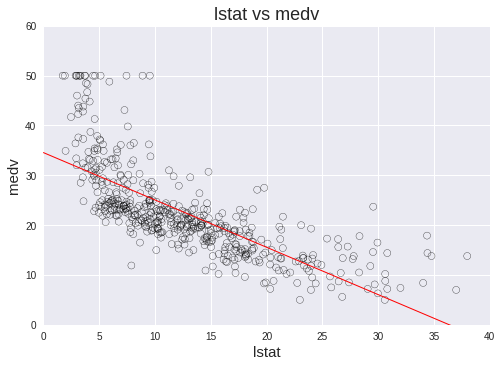

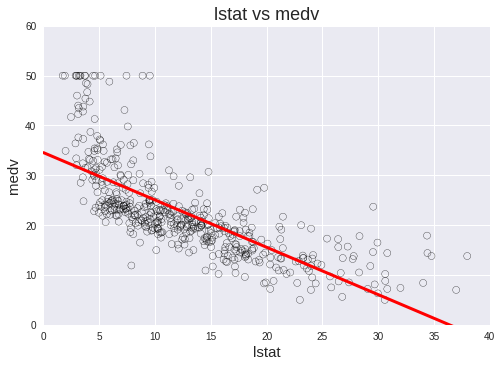

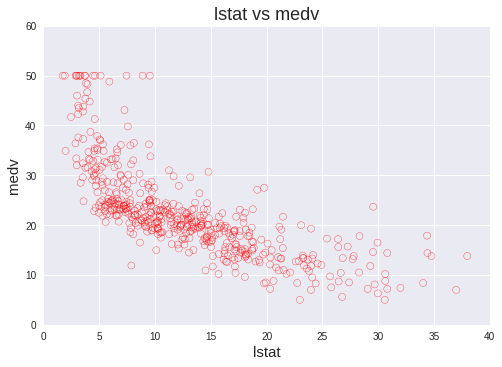

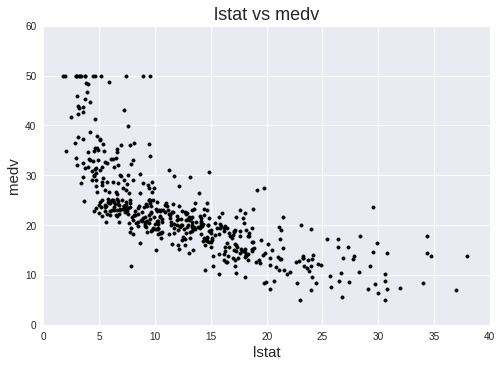

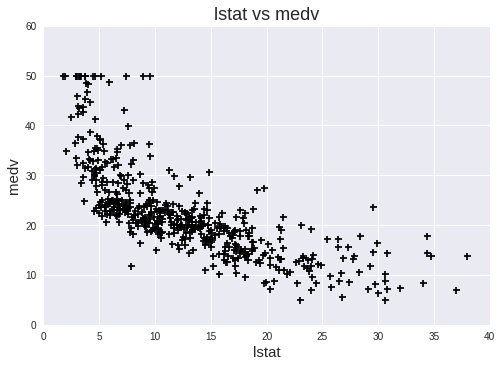

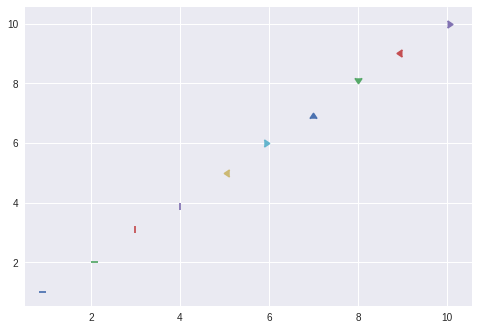

In [63]:

plt.figure()
plt.title("lstat vs medv")
plt.scatter(Boston["lstat"] , Boston["medv"], facecolors='none',edgecolors='k')
plt.plot([0,5, 10, 15,40] , model.predict(pd.DataFrame.from_dict({"lstat":[0,5,10,15,40]})) , 'r' ,linewidth=1.0)
plt.axis([0,40 , 0, 60])
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

plt.figure()
plt.scatter(Boston["lstat"] , Boston["medv"], facecolors='none',edgecolors='k')
plt.title("lstat vs medv")
plt.plot([0,5, 10, 15,40] , model.predict(pd.DataFrame.from_dict({"lstat":[0,5,10,15,40]})) , 'r' ,linewidth=3.0)
plt.axis([0,40 , 0, 60])
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

plt.figure()
plt.title("lstat vs medv")
plt.scatter(Boston["lstat"] , Boston["medv"], facecolors='none',edgecolors='r')
plt.axis([0,40 , 0, 60])
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

plt.figure()
plt.title("lstat vs medv")
plt.scatter(Boston["lstat"] , Boston["medv"], facecolors='k',edgecolors='k' , marker='.')
plt.axis([0,40 , 0, 60])
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

plt.figure()
plt.title("lstat vs medv")
plt.scatter(Boston["lstat"] , Boston["medv"], facecolors='k',edgecolors='k' , marker='+')
plt.axis([0,40 , 0, 60])
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

plt.figure()
x = [x for x in range(1,11)]
y = [y for y in range(1,11)]

cluster = [x for x in range(11)]



for xp, yp, m in zip(x, y, cluster):
    plt.scatter([xp],[yp], marker=m)

plt.show()

['Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Figure',
 'FigureCanvasBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'Number',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotTool',
 'Text',
 'TickHelper',
 'Widget',
 '_INSTALL_FIG_OBSERVER',
 '_IP_REGISTERED',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_auto_draw_if_interactive',
 '_autogen_docstring',
 '_backend_mod',
 '_get_running_interactive_framework',
 '_interactive_bk',
 '_log',
 '_pylab_helpers',
 '_setp',
 '_setup_pyplot_info_docstrings',
 '_show',
 '_string_to_bool',
 'acorr',
 'angle_spec

In [65]:

model.predict(pd.DataFrame.from_dict({"lstat":[0,5,10,15,40]}))

0    34.553841
1    29.803594
2    25.053347
3    20.303101
4    -3.448133
dtype: float64

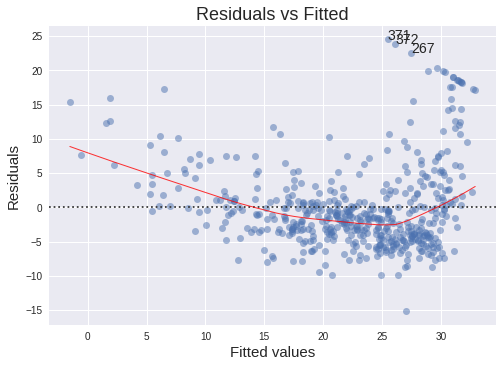

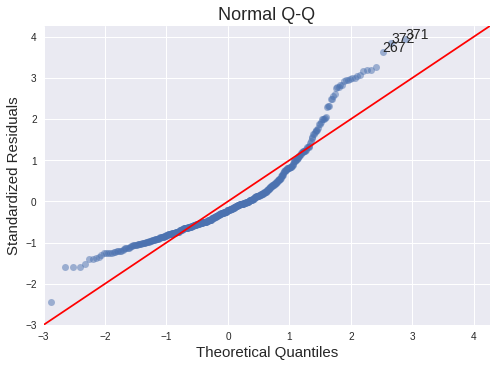

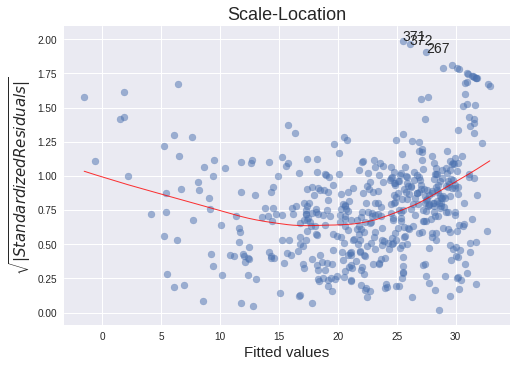

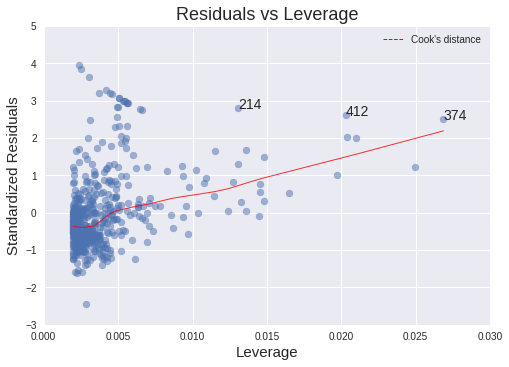

In [74]:

plot(model)

In [67]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           5.08e-88
Time:                        20:26:17   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

# Multiple Linear Regression


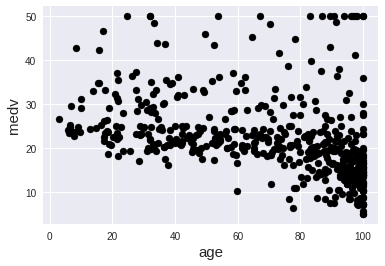

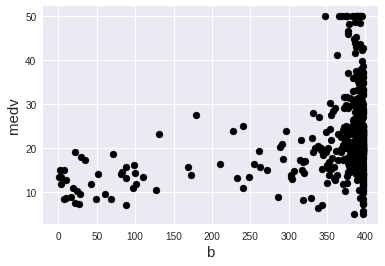

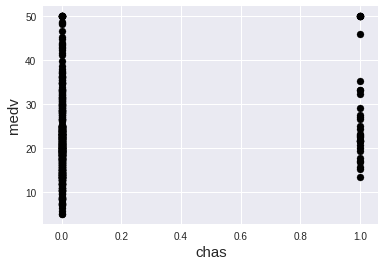

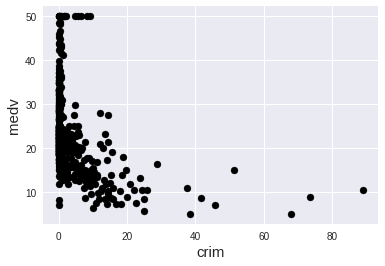

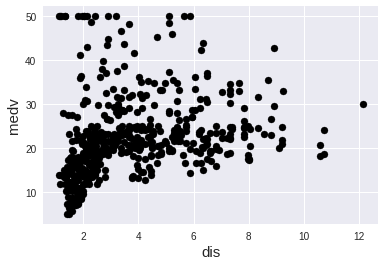

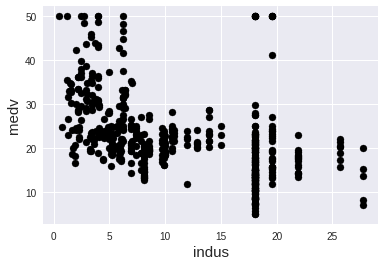

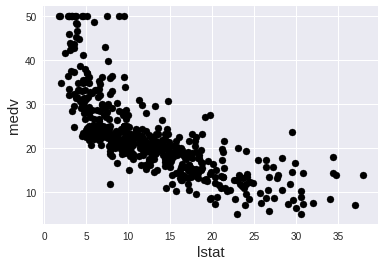

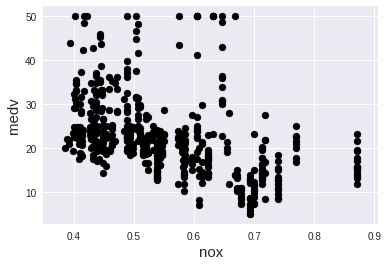

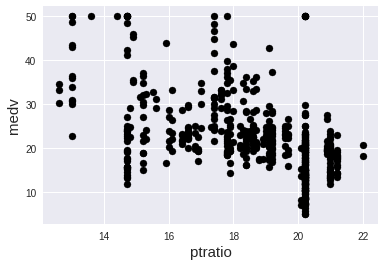

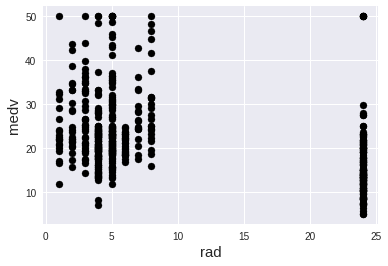

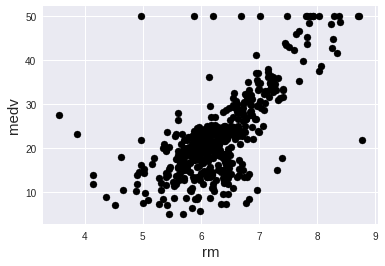

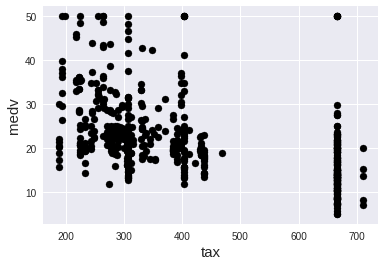

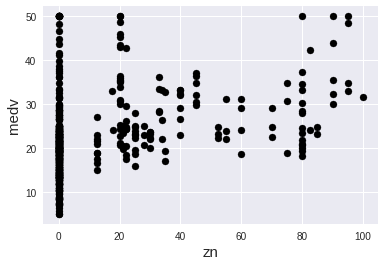

In [22]:
# Plotting various variable against medv
for column in Boston.columns.difference(["medv"]):
    plt.figure()
    plt.scatter(Boston[column] , Boston["medv"], facecolors='k',edgecolors='k')
    plt.xlabel(column)
    plt.ylabel("medv")

    plt.show()

In [23]:
template=lm(formula="medv~lstat+age " , data=Boston)
model=template.fit()

In [24]:

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           2.98e-88
Time:                        20:24:01   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

In [25]:

template=lm(formula="medv~.", data=Boston)
model=template.fit()

In [26]:

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          6.72e-135
Time:                        20:24:01   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

In [27]:
def vif(model):
    
    variables=model.model.exog


    df=pd.DataFrame(variables)

    vif=pd.Series([variance_inflation_factor(df.values , i) for i in range(variables.shape[1])] , index=dict(model.params))
    return vif

In [28]:
vif(model)

Intercept    585.265238
age            3.100826
b              1.348521
chas           1.073995
crim           1.792192
dis            3.955945
indus          3.991596
lstat          2.941491
nox            4.393720
ptratio        1.799084
rad            7.484496
rm             1.933744
tax            9.008554
zn             2.298758
dtype: float64

In [29]:

template=lm(formula="medv~.-age" , data=Boston)
model=template.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     117.3
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          6.08e-136
Time:                        20:24:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3024.
Df Residuals:                     493   BIC:                             3079.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4369      5.080      7.172      0.0

# Interaction Terms

In [30]:
template=lm(formula="medv~lstat*age" , data=Boston)
model=template.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           4.86e-88
Time:                        20:24:02   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

# Non-linear Transformations of the Predictors

In [31]:
template2=lm(formula="medv~lstat+I(lstat**2)" , data=Boston)
model2=template2.fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          1.56e-112
Time:                        20:24:02   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

In [32]:
template=lm(formula="medv~lstat" , data=Boston)
model=template.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           5.08e-88
Time:                        20:24:02   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

In [33]:
print(sm.stats.anova_lm(model , model2))

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


/home/solsec/anaconda3/envs/DSG_Assignment_1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/solsec/anaconda3/envs/DSG_Assignment_1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/solsec/anaconda3/envs/DSG_Assignment_1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


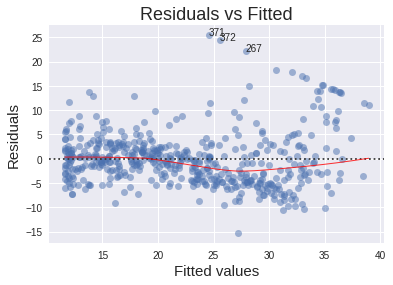

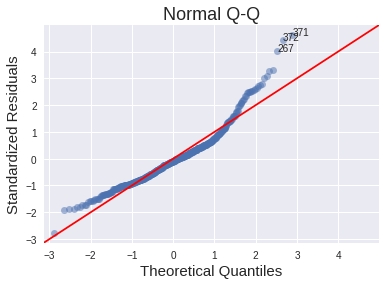

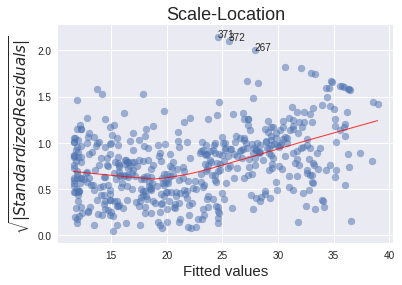

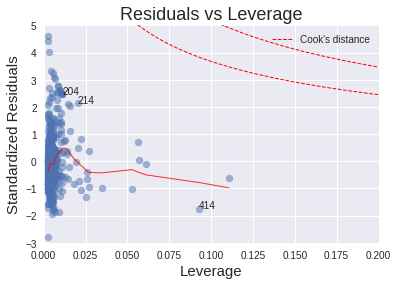

In [34]:
plot(model2)

In [35]:
poly_features="+".join(["I(lstat**"+str(i)+")" for i in range(1,6)])
formula = "medv~" + poly_features
template=lm(formula=formula , data=Boston)
model=template.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          8.73e-122
Time:                        20:24:03   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        67.6997      3.604     18.783

## Qualitative Predictors

In [36]:
Carseats=pd.read_csv("datasets/Carseats.csv")

In [37]:
names(Carseats)

['Sales',
 'CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'ShelveLoc',
 'Age',
 'Education',
 'Urban',
 'US']

In [38]:


template=lm(formula = "Sales~.+ Income : Advertising + Price : Age" , data=Carseats)
model=template.fit()

In [39]:

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          6.14e-166
Time:                        20:24:04   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756    

In [40]:
from patsy.contrasts import Treatment

contrast=Treatment().code_without_intercept(pd.unique(Carseats["ShelveLoc"]).tolist())

In [41]:
row_index=pd.unique(Carseats["ShelveLoc"]).tolist()

In [42]:
print(row_index)

['Bad', 'Good', 'Medium']


In [43]:
columns_index=(contrast.column_suffixes)

In [44]:
contrast_data_frame=pd.DataFrame(contrast.matrix, columns=columns_index , index=row_index)

In [45]:
contrast_data_frame

,[T.Good],[T.Medium]
Bad,0.0,0.0
Good,1.0,0.0
Medium,0.0,1.0
